In [2]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

## Fetch Nordpool Volumes and Prices in the Day Ahead Auction so we can compare to the National Demand

In [3]:
from scrapers.nordpool import scrape_nordpool, scrape_nordpool_volumes
from scrapers.elexon import get_apx_market_index, get_demand_outturn_stream, get_actual_total_load
from datetime import datetime, timedelta

SETTLEMENT_DATE = "2025-11-21"
SETTLEMENT_DATE_TO_COMPARE = "2025-09-21"
dt = datetime.strptime(SETTLEMENT_DATE, "%Y-%m-%d")
day_before = (dt - timedelta(days=1)).strftime("%Y-%m-%d"); day_after  = (dt + timedelta(days=1)).strftime("%Y-%m-%d")

In [4]:
nord_pool_df = scrape_nordpool(SETTLEMENT_DATE)
print(f"Extracted {len(nord_pool_df)} rows")
nord_pool_volumes_df = scrape_nordpool_volumes(SETTLEMENT_DATE)
print(f"Extracted {len(nord_pool_volumes_df)} rows")
apx_data = get_apx_market_index(day_before, day_after).query('settlementDate == @SETTLEMENT_DATE')
print(f"Extracted {len(apx_data)} rows")
apx_data_sorted = apx_data[['settlementPeriod', 'price', 'volume']].drop_duplicates().sort_values('settlementPeriod')

Loading prices from cache: 2025-11-21
Extracted 24 rows
Loading volumes from cache: 2025-11-21
Extracted 24 rows
Extracted 48 rows


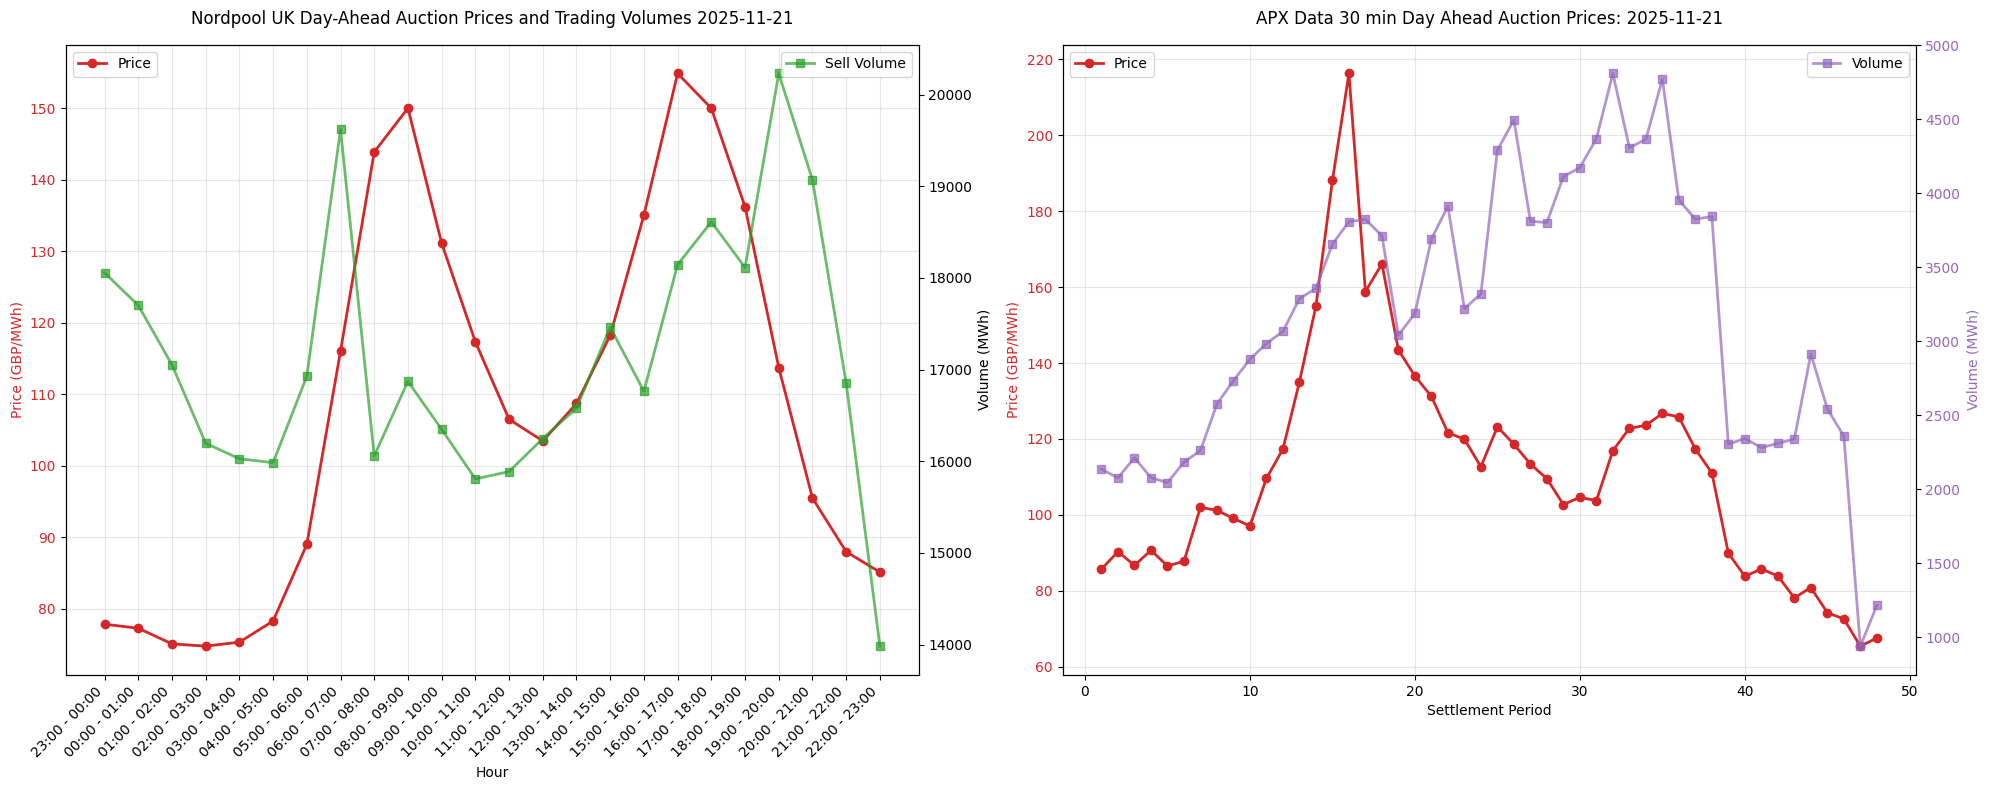

In [5]:
from plot_generation_stack import plot_price_volume_comparison

plot_price_volume_comparison(SETTLEMENT_DATE, nord_pool_df, nord_pool_volumes_df, apx_data_sorted)

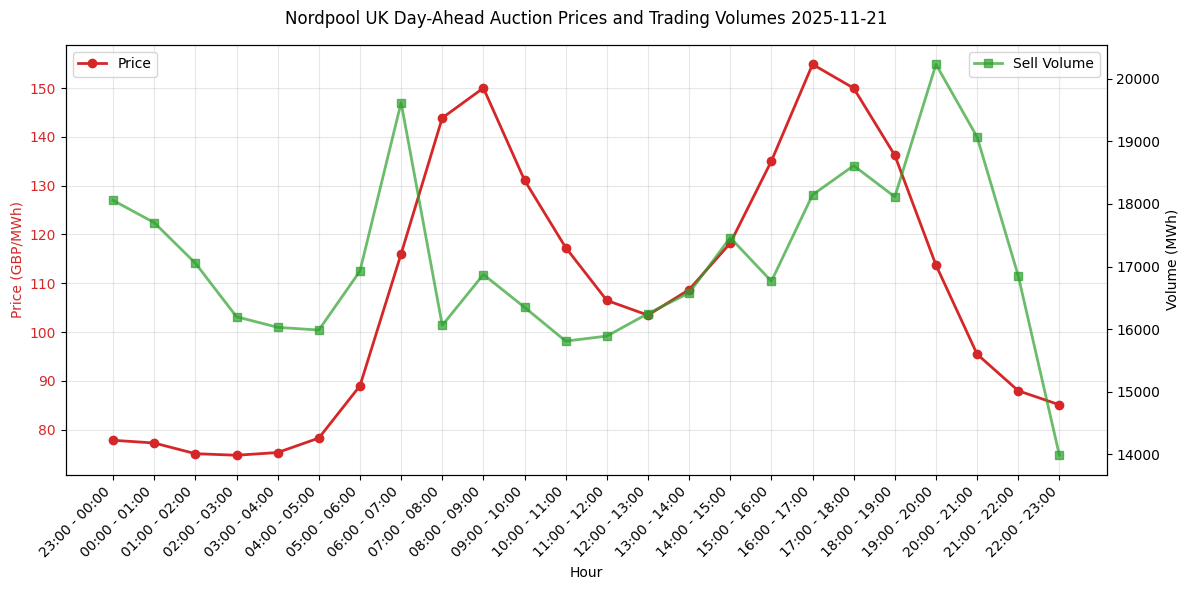

In [6]:

from plot_generation_stack import plot_nordpool_price_volume
plot_nordpool_price_volume(SETTLEMENT_DATE, nord_pool_df, nord_pool_volumes_df)

Loading prices from cache: 2025-09-21
Loading volumes from cache: 2025-09-21


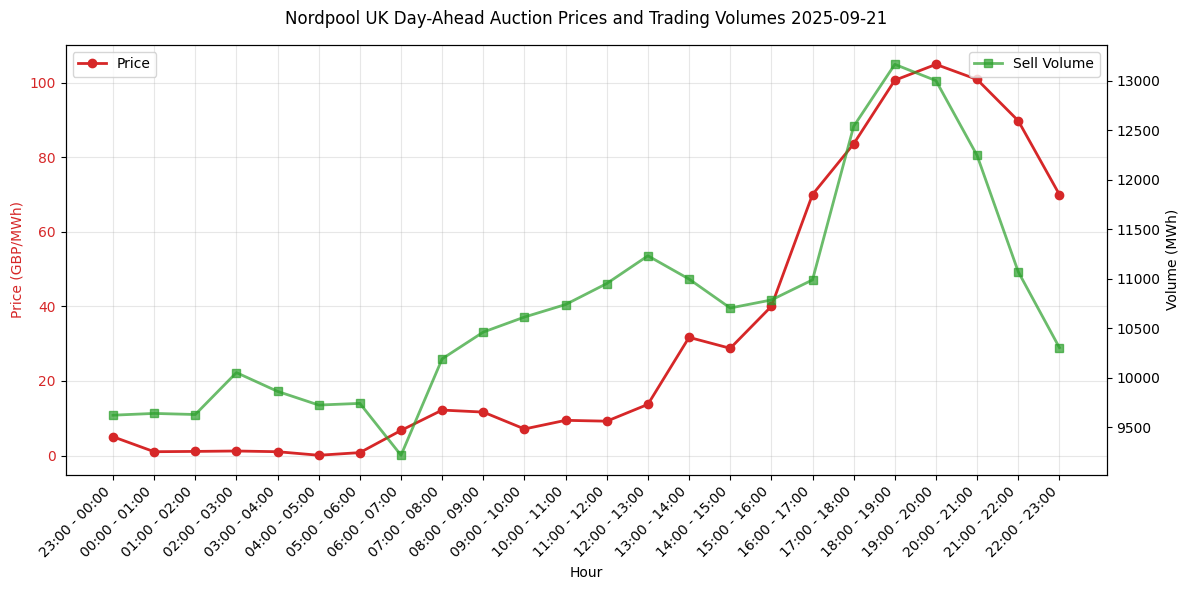

In [7]:
nord_pool_df_compare = scrape_nordpool(SETTLEMENT_DATE_TO_COMPARE)
nord_pool_volumes_df_compare = scrape_nordpool_volumes(SETTLEMENT_DATE_TO_COMPARE)
comparison_dates = [SETTLEMENT_DATE, SETTLEMENT_DATE_TO_COMPARE]
plot_nordpool_price_volume(SETTLEMENT_DATE_TO_COMPARE, nord_pool_df_compare, nord_pool_volumes_df_compare)

## Fetch Current Day Actual Demand from Elexon

In [8]:
demand_outturn = get_demand_outturn_stream(SETTLEMENT_DATE,SETTLEMENT_DATE)
actual_demand_load = get_actual_total_load(SETTLEMENT_DATE)
actual_demand_load.sort_values('settlementPeriod', inplace=True)
hourly_demand = demand_outturn.groupby(['hour'],as_index=False)['initialDemandOutturn'].mean()
hourly_demand.shape

(24, 2)

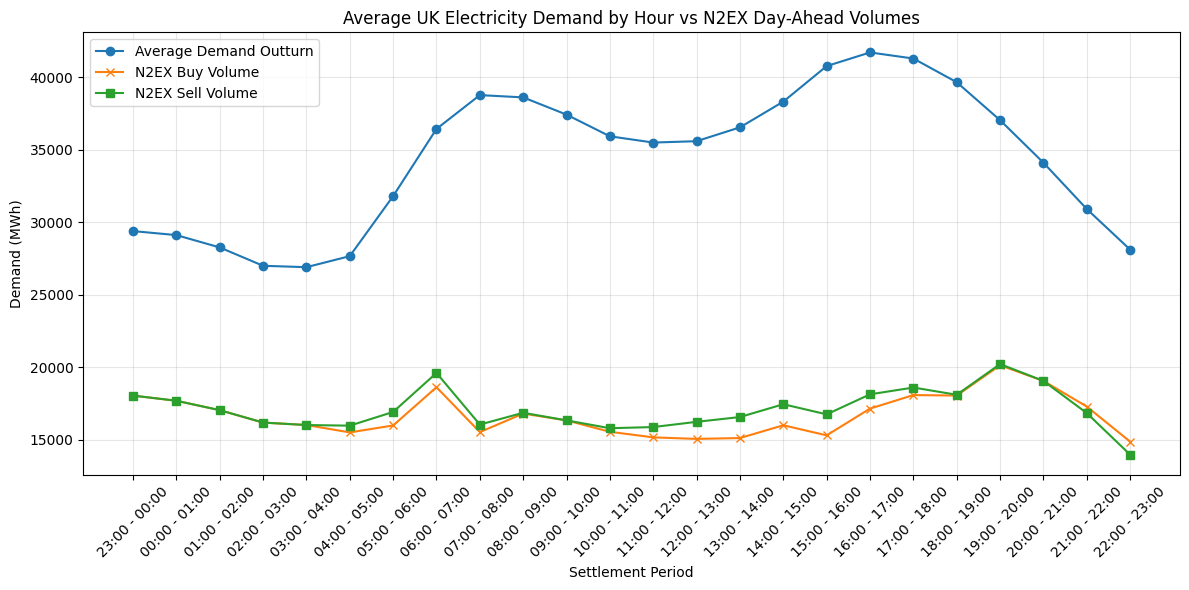

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Average UK Electricity Demand by Hour vs N2EX Day-Ahead Volumes')
plt.plot(hourly_demand['hour'], hourly_demand['initialDemandOutturn'], marker='o', label='Average Demand Outturn')
plt.plot(nord_pool_volumes_df['period'], nord_pool_volumes_df['buy_volume'], marker='x', label='N2EX Buy Volume')
plt.plot(nord_pool_volumes_df['period'], nord_pool_volumes_df['sell_volume'], marker='s', label='N2EX Sell Volume')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Settlement Period'); plt.ylabel('Demand (MWh)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


Loading from cache: ../cache/generation_fuel_2025-11-21_2025-11-21.pkl


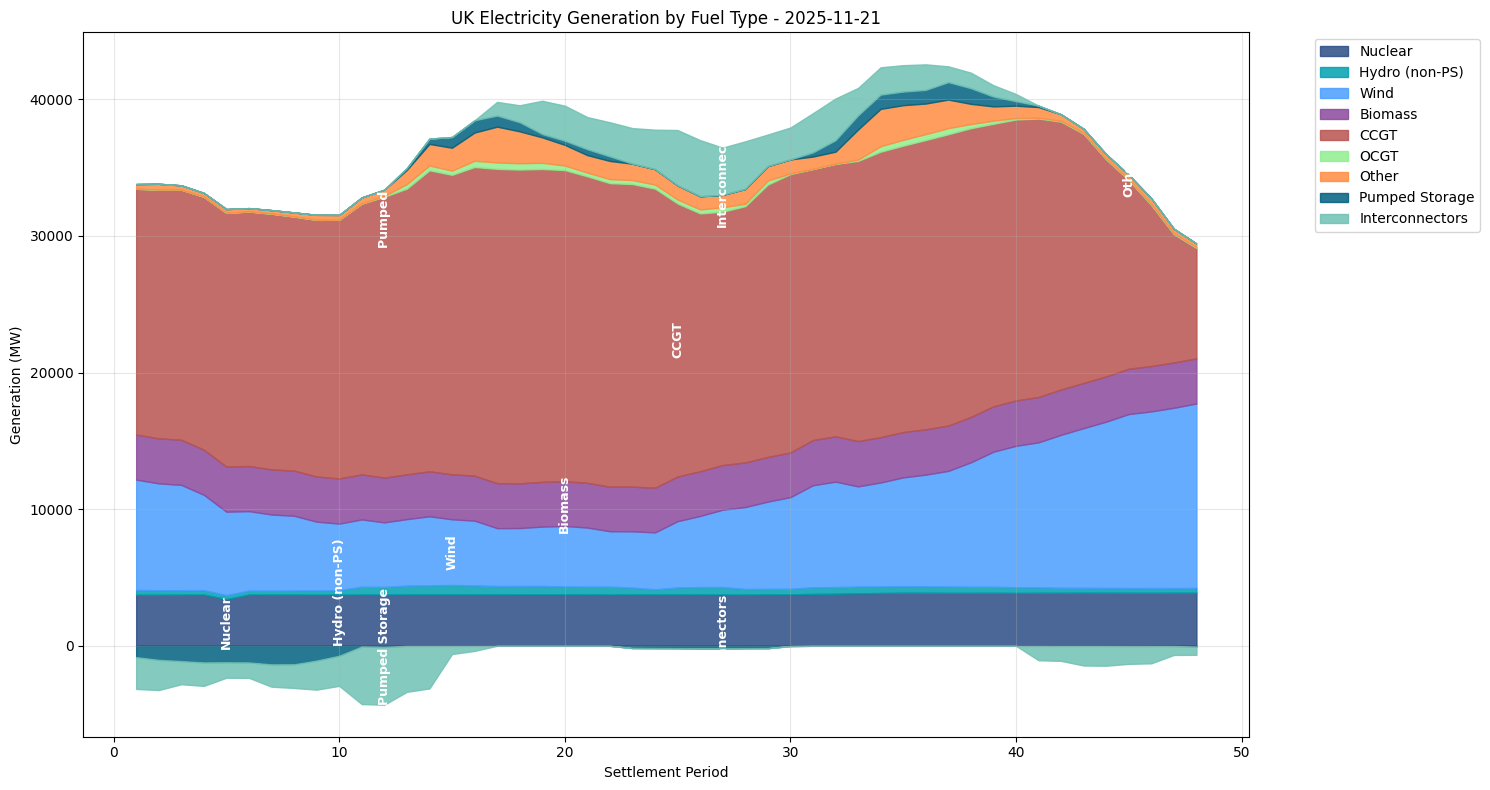

In [10]:
from plot_generation_stack import create_generation_stack_chart, create_percentage_stack_chart
create_generation_stack_chart(SETTLEMENT_DATE)

Loading from cache: ../cache/generation_fuel_2025-11-21_2025-11-21.pkl


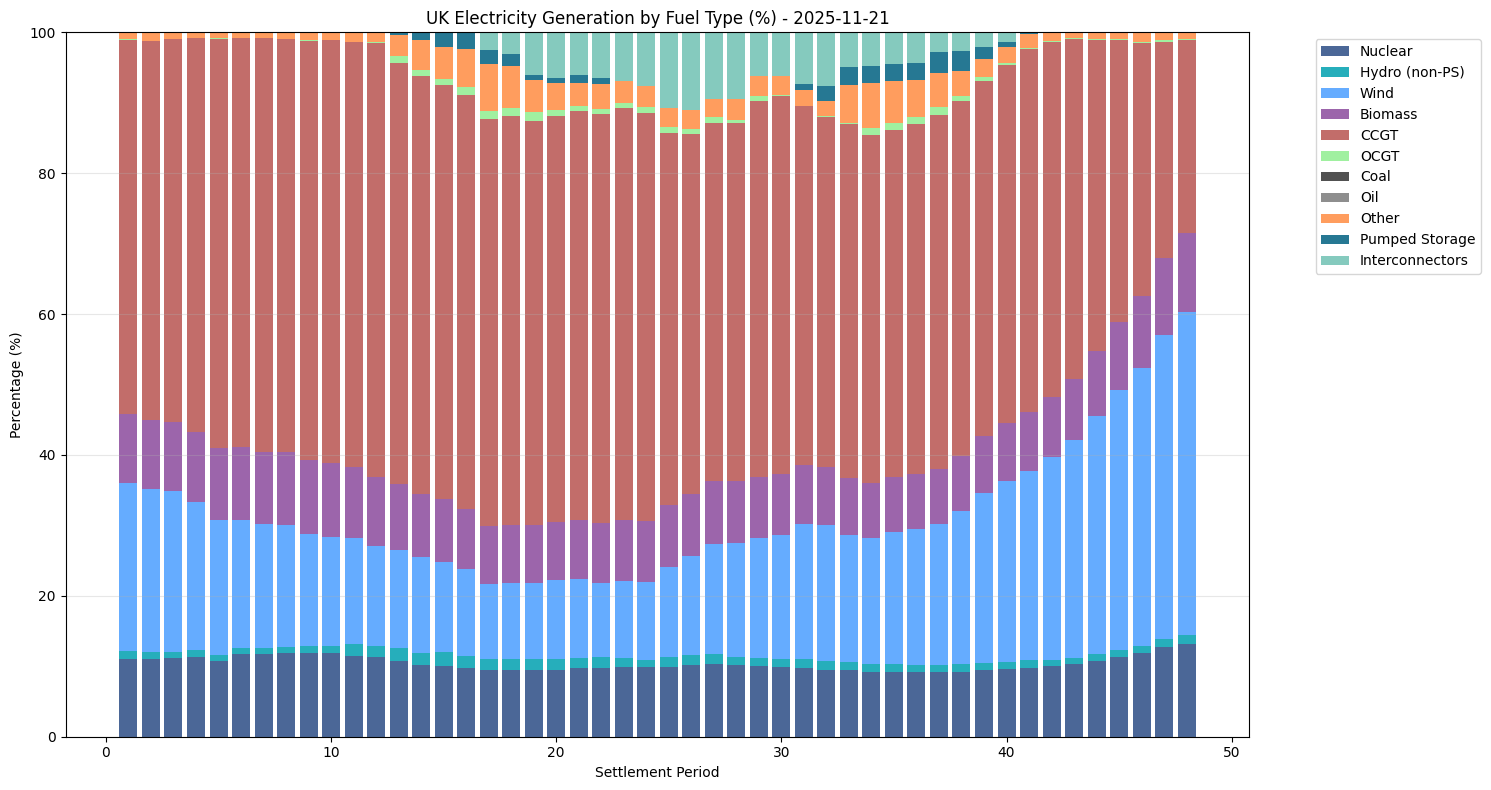

In [11]:
create_percentage_stack_chart(SETTLEMENT_DATE)

Loading from cache: ../cache/generation_fuel_2025-11-21_2025-11-21.pkl


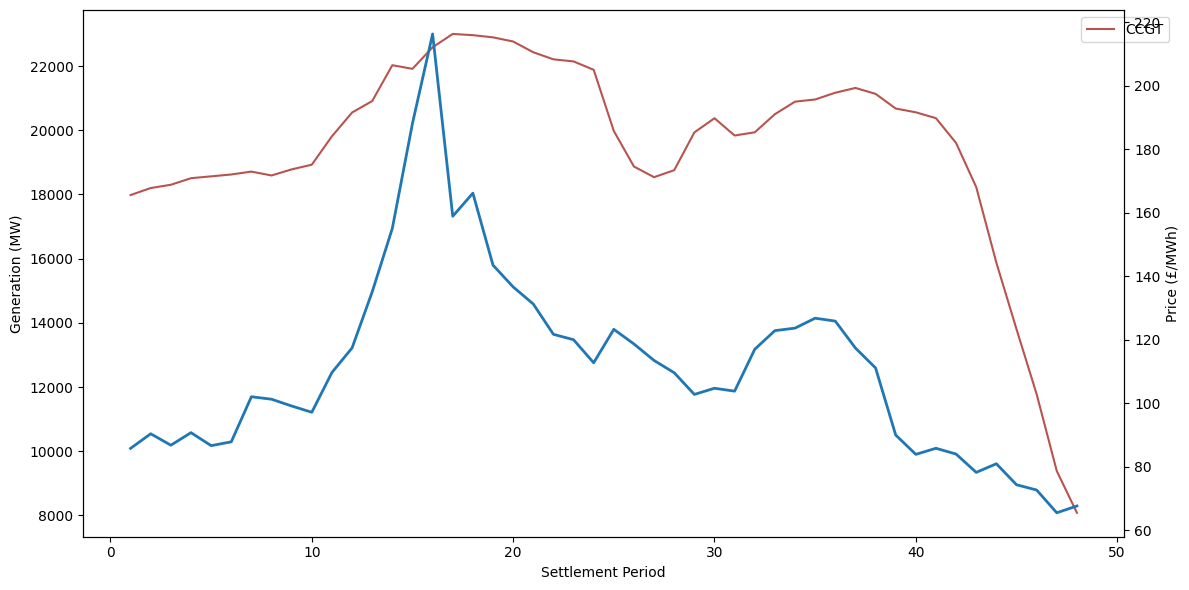

In [12]:
from plot_generation_stack import plot_ccgt_vs_price
plot_ccgt_vs_price(SETTLEMENT_DATE, apx_data=apx_data_sorted)

In [22]:
from scrapers.elexon import get_balancing_acceptances_all_day, analyze_balancing_costs_simple, get_acceptances_with_prices, get_acceptances_with_fuel_types
acceptances_all_day = get_balancing_acceptances_all_day(SETTLEMENT_DATE)


In [17]:
acceptances_all_day.head(600).to_csv("acceptances_all_day.csv", index=False)

In [20]:
get_acceptances_with_prices(SETTLEMENT_DATE)

,settlementDate,settlementPeriodFrom,settlementPeriodTo,timeFrom_acceptance,timeTo_acceptance,levelFrom_acceptance,levelTo_acceptance,nationalGridBmUnit_acceptance,bmUnit,acceptanceNumber,...,rrFlag,settlementPeriod,nationalGridBmUnit_bid_offer,timeFrom_bid_offer,timeTo_bid_offer,levelFrom_bid_offer,levelTo_bid_offer,bid,offer,pairId
1789,2025-11-21,1,1,2025-11-21T00:27:00Z,2025-11-21T00:29:00Z,-8,-8,LKSDB-1,T_LKSDB-1,26805,...,False,1,LKSDB-1,2025-11-21T00:00:00Z,2025-11-21T00:30:00Z,-100,-100,-99999.00,-99999.0,-2
1790,2025-11-21,1,1,2025-11-21T00:27:00Z,2025-11-21T00:29:00Z,-8,-8,LKSDB-1,T_LKSDB-1,26805,...,False,1,LKSDB-1,2025-11-21T00:00:00Z,2025-11-21T00:30:00Z,-100,-100,68.00,130.0,-1
1791,2025-11-21,1,1,2025-11-21T00:27:00Z,2025-11-21T00:29:00Z,-8,-8,LKSDB-1,T_LKSDB-1,26805,...,False,1,LKSDB-1,2025-11-21T00:00:00Z,2025-11-21T00:30:00Z,100,100,68.00,130.0,1
1792,2025-11-21,1,1,2025-11-21T00:27:00Z,2025-11-21T00:29:00Z,-8,-8,LKSDB-1,T_LKSDB-1,26805,...,False,1,LKSDB-1,2025-11-21T00:00:00Z,2025-11-21T00:30:00Z,100,100,99999.00,99999.0,2
2237,2025-11-21,1,1,2025-11-21T00:26:00Z,2025-11-21T00:28:00Z,842,844,LAGA-1,T_LAGA-1,161438,...,False,1,LAGA-1,2025-11-21T00:00:00Z,2025-11-21T00:30:00Z,-900,-900,5.00,50.0,-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209718,2025-11-21,46,1,2025-11-21T22:38:00Z,2025-11-22T00:00:00Z,0,0,FASN3,E_FASN-3,83826,...,False,44,FASN3,2025-11-21T21:30:00Z,2025-11-21T22:00:00Z,200,200,80.00,100.0,1
3209719,2025-11-21,46,1,2025-11-21T22:38:00Z,2025-11-22T00:00:00Z,0,0,FASN3,E_FASN-3,83826,...,False,45,FASN3,2025-11-21T22:00:00Z,2025-11-21T22:30:00Z,-200,-200,65.01,70.0,-1
3209720,2025-11-21,46,1,2025-11-21T22:38:00Z,2025-11-22T00:00:00Z,0,0,FASN3,E_FASN-3,83826,...,False,45,FASN3,2025-11-21T22:00:00Z,2025-11-21T22:30:00Z,200,200,80.00,100.0,1
3209721,2025-11-21,46,1,2025-11-21T22:38:00Z,2025-11-22T00:00:00Z,0,0,FASN3,E_FASN-3,83826,...,False,46,FASN3,2025-11-21T22:30:00Z,2025-11-21T23:00:00Z,-200,-200,65.01,70.0,-1


In [ ]:
get_acceptances_with_fuel_types(SETTLEMENT_DATE)

10{"stdout":"","stderr":"","mime":[]}
